In [1]:
import torch
from avalanche.evaluation.metrics import Accuracy, TaskAwareAccuracy

# create an instance of the standalone Accuracy metric
# initial accuracy is 0
acc_metric = Accuracy()
print("Initial Accuracy: ", acc_metric.result()) #  output 0.0

# two consecutive metric updates
real_y = torch.tensor([1, 2]).long()
predicted_y = torch.tensor([1, 0]).float()
acc_metric.update(real_y, predicted_y)
acc = acc_metric.result()
print("Average Accuracy: ", acc) # output 0.5
predicted_y = torch.tensor([1,2]).float()
acc_metric.update(real_y, predicted_y)
acc = acc_metric.result()
print("Average Accuracy: ", acc) # output 0.75

# reset accuracy
acc_metric.reset()
print("After reset: ", acc_metric.result()) # output 0.0

2024-12-17 20:37:21.196923: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-17 20:37:21.234597: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-17 20:37:21.246220: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 20:37:21.270108: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-17 20:37:22.867135: W tensorflow/comp

Initial Accuracy:  0.0
Average Accuracy:  0.5
Average Accuracy:  0.75
After reset:  0.0


/home/yangz2/anaconda3/envs/quan_cl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# create an instance of the standalone TaskAwareAccuracy metric
# initial accuracy is 0 for each task
acc_metric = TaskAwareAccuracy()
print("Initial Accuracy: ", acc_metric.result()) #  output {}

# metric updates for 2 different tasks
task_label = 0
real_y = torch.tensor([1, 2]).long()
print(real_y)
predicted_y = torch.tensor([1, 0]).float()
print(predicted_y)
acc_metric.update(real_y, predicted_y, task_label)
acc = acc_metric.result()
print("Average Accuracy: ", acc) # output 0.5 for task 0

task_label = 1
predicted_y = torch.tensor([1,2]).float()
print(predicted_y)
acc_metric.update(real_y, predicted_y, task_label)
acc = acc_metric.result() 
print("Average Accuracy: ", acc) # output 0.75 for task 0 and 1.0 for task 1

task_label = 0
predicted_y = torch.tensor([1,2]).float()
print(predicted_y)
acc_metric.update(real_y, predicted_y, task_label)
acc = acc_metric.result()
print("Average Accuracy: ", acc) # output 0.75 for task 0 and 1.0 for task 1

# reset accuracy
acc_metric.reset()
print("After reset: ", acc_metric.result()) # output {}

Initial Accuracy:  {}
tensor([1, 2])
tensor([1., 0.])
Average Accuracy:  {0: 0.5}
tensor([1., 2.])
Average Accuracy:  {0: 0.5, 1: 1.0}
tensor([1., 2.])
Average Accuracy:  {0: 0.75, 1: 1.0}
After reset:  {}


In [7]:
from avalanche.evaluation.metrics import accuracy_metrics, \
    loss_metrics, forgetting_metrics, bwt_metrics,\
    confusion_matrix_metrics, cpu_usage_metrics, \
    disk_usage_metrics, gpu_usage_metrics, MAC_metrics, \
    ram_usage_metrics, timing_metrics

# you may pass the result to the EvaluationPlugin
metrics = accuracy_metrics(epoch=True, experience=True)

In [20]:
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from avalanche.benchmarks.classic import SplitMNIST
from avalanche.evaluation.metrics import forgetting_metrics, \
accuracy_metrics, loss_metrics, timing_metrics, cpu_usage_metrics, \
confusion_matrix_metrics, disk_usage_metrics
from avalanche.models import SimpleMLP
from avalanche.logging import InteractiveLogger
from avalanche.training.plugins import EvaluationPlugin
from avalanche.training import Naive
from avalanche.training.supervised.icarl import ICaRL
from torch.nn import BCEWithLogitsLoss

benchmark = SplitMNIST(n_experiences=10)

# MODEL CREATION
model = SimpleMLP(num_classes=benchmark.n_classes)

# Replace CrossEntropyLoss with BCEWithLogitsLoss
criterion = BCEWithLogitsLoss()
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)

# DEFINE THE EVALUATION PLUGIN
# The evaluation plugin manages the metrics computation.
# It takes as argument a list of metrics, collectes their results and returns
# them to the strategy it is attached to.

eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    loss_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    timing_metrics(epoch=True),
    forgetting_metrics(experience=True, stream=True),
    cpu_usage_metrics(experience=True),
    confusion_matrix_metrics(num_classes=benchmark.n_classes, save_image=False, stream=True),
    disk_usage_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    loggers=[InteractiveLogger()],
    strict_checks=False
)

# CREATE THE STRATEGY INSTANCE (NAIVE)
cl_strategy = Naive(
    model, SGD(model.parameters(), lr=0.001, momentum=0.9),
    CrossEntropyLoss(), train_mb_size=500, train_epochs=30, eval_mb_size=100,
    evaluator=eval_plugin)



# TRAINING LOOP
print('Starting experiment...')
results = []
for experience in benchmark.train_stream:
    # train returns a dictionary which contains all the metric values
    res = cl_strategy.train(experience)
    print('Training completed')

    print('Computing accuracy on the whole test set')
    # test also returns a dictionary which contains all the metric values
    results.append(cl_strategy.eval(benchmark.test_stream))



Starting experiment...
-- >> Start of training phase << --
0it [00:00, ?it/s]

TypeError: 'SGD' object is not callable

In [1]:
from avalanche.benchmarks.classic import SplitCIFAR100
from avalanche.training.supervised.icarl import ICaRL
from avalanche.evaluation.metrics import (
    forgetting_metrics, accuracy_metrics, loss_metrics, timing_metrics, cpu_usage_metrics, confusion_matrix_metrics, disk_usage_metrics
)
from avalanche.logging import InteractiveLogger, TensorboardLogger, TextLogger
from avalanche.training.plugins import EvaluationPlugin
from torch.optim import SGD
from torch.nn import BCEWithLogitsLoss, Identity
import torch.nn as nn

# Define benchmark
benchmark = SplitCIFAR100(n_experiences=10, return_task_id=False, seed=42)

# Define CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Linear(64 * 8 * 8, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

# Initialize feature extractor and classifier
feature_extractor = SimpleCNN(num_classes=benchmark.n_classes)
classifier = feature_extractor.classifier  # Use the last layer as classifier
feature_extractor.classifier = Identity()  # Remove the last layer for feature extraction

loggers = []
# log to Tensorboard
loggers.append(TensorboardLogger())
# log to text file
loggers.append(TextLogger(open('avalanche_logger_log.txt', 'a')))
# print to stdout
loggers.append(InteractiveLogger())
# Define evaluation plugin

eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=True, epoch=True, stream=True, experience=True),
    loss_metrics(minibatch=True, epoch=True, stream=True, experience=True),
    forgetting_metrics(experience=True, stream=True),
    timing_metrics(epoch=True, stream=True, experience=True),
    # cpu_usage_metrics(experience=True),
    # disk_usage_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    confusion_matrix_metrics(num_classes=benchmark.n_classes, save_image=True, stream=True),
    loggers=loggers
)

# Define optimizer
optimizer = SGD(
    list(feature_extractor.parameters()) + list(classifier.parameters()), 
    lr=0.1, momentum=0.9
)

# Define iCaRL strategy
cl_strategy = ICaRL(
    feature_extractor=feature_extractor,
    classifier=classifier,
    optimizer=optimizer,
    memory_size=2000,
    evaluator=eval_plugin,
    train_mb_size=64,
    train_epochs=30,
    eval_mb_size=128,
    device="cuda",
    buffer_transform=None,  # 不对记忆库中的样本进行额外变换
    fixed_memory=True       # 固定记忆库大小
)

# Training loop
print('Starting iCaRL strategy...')
results = []

for experience in benchmark.train_stream:
    print(f"Training on experience {experience.current_experience}...")
    cl_strategy.train(experience)
    print("Training completed!")

    print("Evaluating on test stream...")
    results.append(cl_strategy.eval(benchmark.test_stream))


2024-12-26 15:58:25.718964: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-26 15:58:25.756882: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-26 15:58:25.768583: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-26 15:58:25.792770: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-26 15:58:27.463262: W tensorflow/comp

Files already downloaded and verified
Files already downloaded and verified
Starting iCaRL strategy...
Training on experience 0...
-- >> Start of training phase << --
100%|██████████| 79/79 [00:02<00:00, 29.64it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0700
	Loss_MB/train_phase/train_stream/Task000 = 0.0211
	Time_Epoch/train_phase/train_stream/Task000 = 2.6685
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.2490
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.5000
100%|██████████| 79/79 [00:03<00:00, 21.70it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0247
	Loss_MB/train_phase/train_stream/Task000 = 0.0217
	Time_Epoch/train_phase/train_stream/Task000 = 3.6409
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.4414
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.5000
100%|██████████| 79/79 [00:02<00:00, 31.47it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0234
	Loss_MB/train_phase/train_stream/Task000 = 0.

In [2]:
print(results)

[{'Top1_Acc_MB/train_phase/train_stream/Task000': 0.875, 'Loss_MB/train_phase/train_stream/Task000': 0.009492961689829826, 'Top1_Acc_Epoch/train_phase/train_stream/Task000': 0.6892, 'Loss_Epoch/train_phase/train_stream/Task000': 0.01565611182153225, 'Time_Epoch/train_phase/train_stream/Task000': 3.138771014288068, 'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000': 0.547, 'Loss_Exp/eval_phase/test_stream/Task000/Exp000': 0.32770479822158816, 'Time_Exp/eval_phase/test_stream/Task000/Exp000': 0.5421248963102698, 'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001': 0.0, 'Loss_Exp/eval_phase/test_stream/Task000/Exp001': 0.332213751077652, 'Time_Exp/eval_phase/test_stream/Task000/Exp001': 0.4144020928069949, 'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002': 0.0, 'Loss_Exp/eval_phase/test_stream/Task000/Exp002': 0.33222535347938537, 'Time_Exp/eval_phase/test_stream/Task000/Exp002': 0.4268749561160803, 'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp003': 0.0, 'Loss_Exp/eval_phase/test

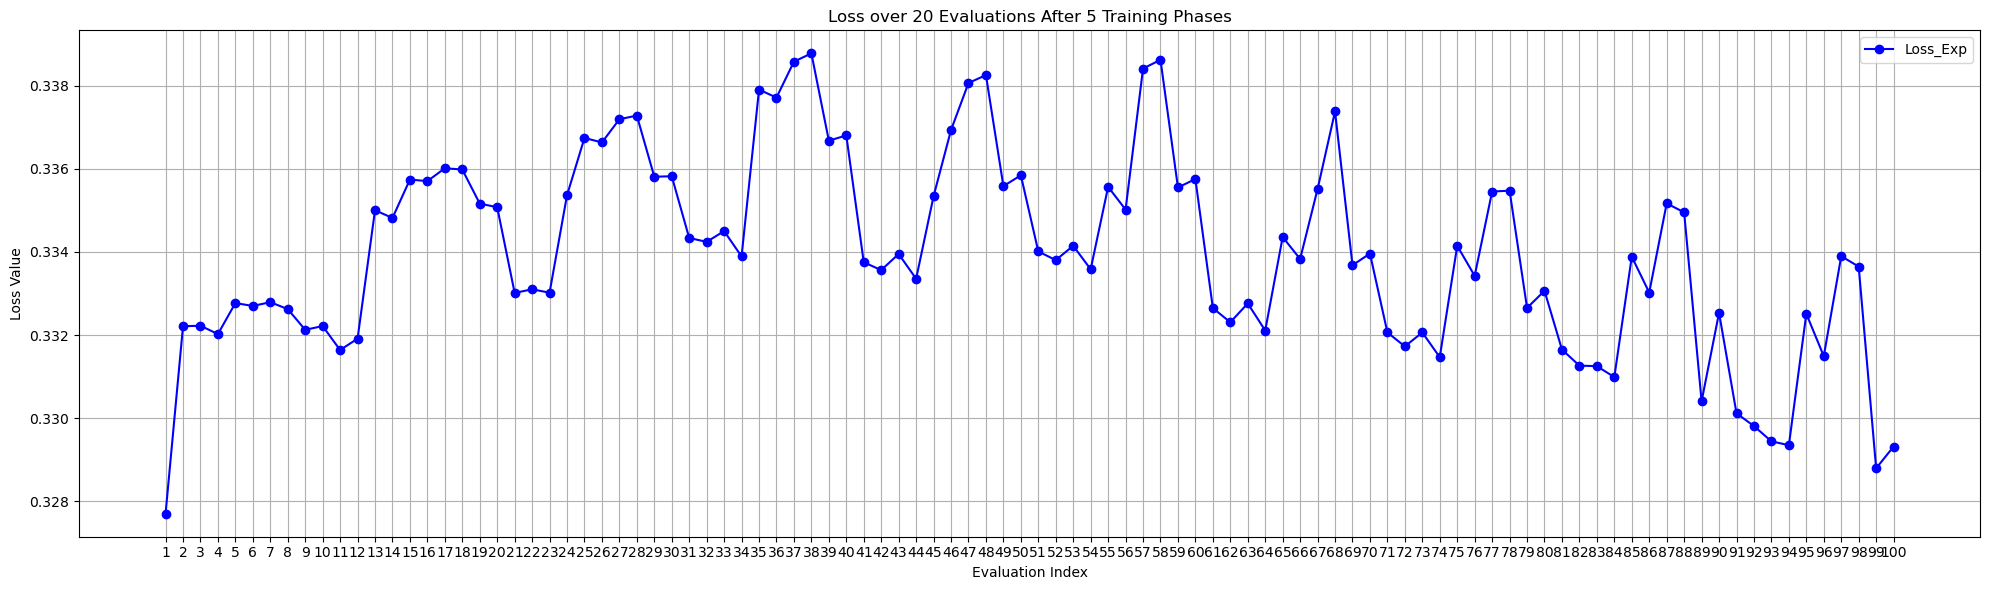

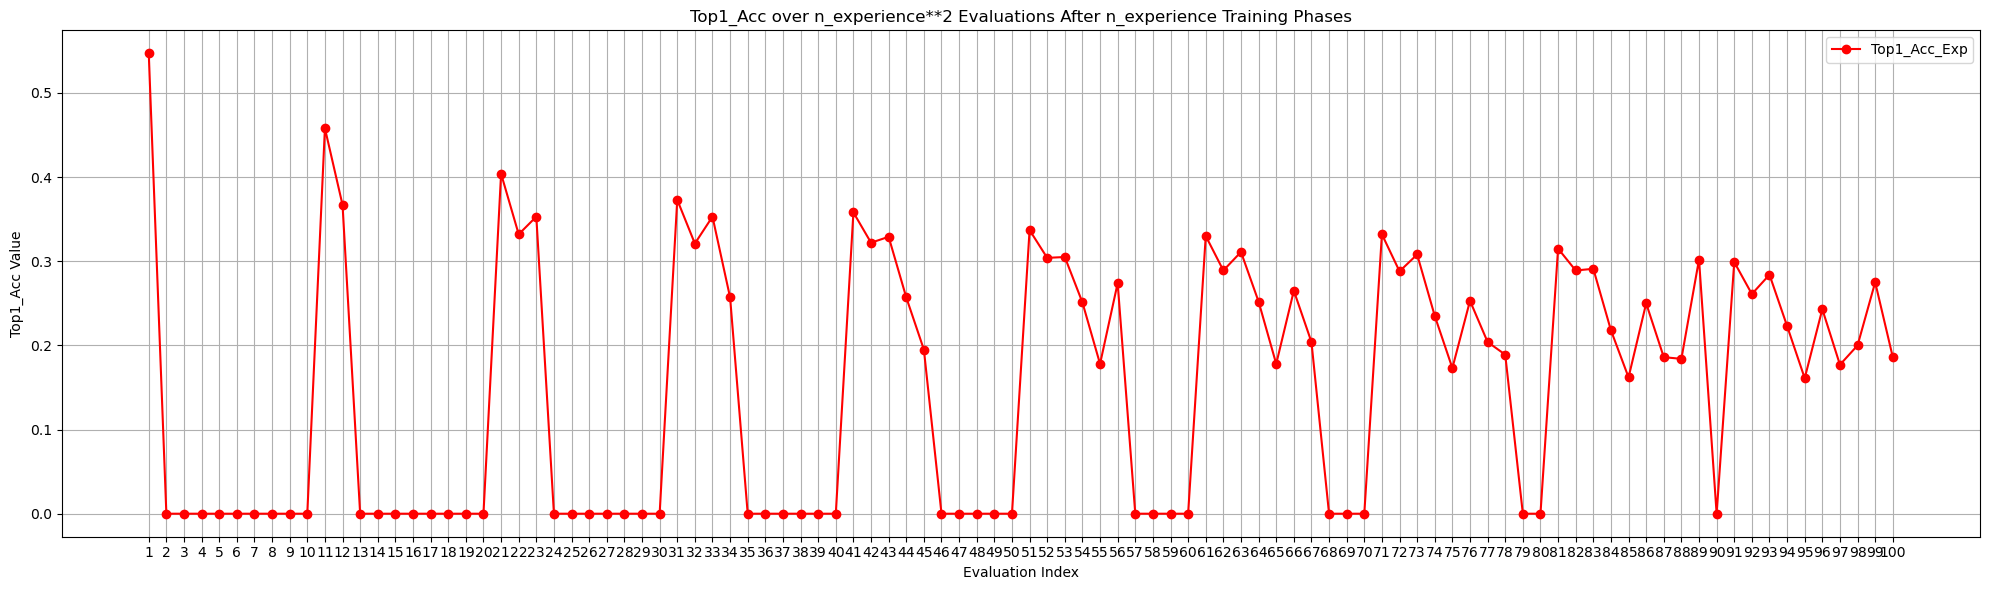

In [3]:
import matplotlib.pyplot as plt
# 初始化列表来存储 Loss 值
loss_values = []
x = []  # x 轴：经验编号（1-20）

# 遍历 results 提取 Loss_Exp 数据
count = 1  # 用于标记经验编号
for train_idx, result in enumerate(results):  # 遍历5次训练的结果
    for exp_id in range(0, 10):  # 每次训练对应4次 eval（Exp001 到 Exp004）
        key = f"Loss_Exp/eval_phase/test_stream/Task000/Exp00{exp_id}"
        loss = result.get(key, None)
        if loss is not None:  # 确保键存在
            loss_values.append(loss)
            x.append(count)  # x 轴连续编号
            count += 1

# 遍历 results 提取 Top1_Acc_Exp 数据
top1_acc_values = []
for train_idx, result in enumerate(results):  # 遍历5次训练的结果
    for exp_id in range(0, 10):  # 每次训练对应4次 eval（Exp001 到 Exp004）
        key = f"Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp00{exp_id}"
        top1_acc = result.get(key, None)
        if top1_acc is not None:  # 确保键存在
            top1_acc_values.append(top1_acc)

# 绘制图形
plt.figure(figsize=(20, 6))
plt.plot(x, loss_values, marker='o', linestyle='-', color='b', label='Loss_Exp')
plt.title("Loss over 20 Evaluations After 5 Training Phases")
plt.xlabel("Evaluation Index")
plt.ylabel("Loss Value")
plt.xticks(range(1, len(x) + 1))  # 设置 x 轴刻度
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 6))
plt.plot(x, top1_acc_values, marker='o', linestyle='-', color='r', label='Top1_Acc_Exp')
plt.title("Top1_Acc over n_experience**2 Evaluations After n_experience Training Phases")
plt.xlabel("Evaluation Index")
plt.ylabel("Top1_Acc Value")
plt.xticks(range(1, len(x) + 1))  # 设置 x 轴刻度
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
%load_ext tensorboard